# 軸受の世界へようこそ
* 転がり軸受の振動データから異常を検出するためのアルゴリズムを考えます。
* ソースの説明
    * [Bearing Vibration Data under Time-varying Rotational Speed Conditions](https://data.mendeley.com/datasets/v43hmbwxpm/1)
    * ライセンス：CC BY 4.0 → 商用利用も可能
    * 200,000Hzで10秒間の測定

In [16]:
import os
from betapack.cmdstanpy import CmdStanModel
from pathlib import Path
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy.io
import pandas as pd

## データ読込

In [74]:
cond1 = "A"
cond2 = 3
dat_healthy = scipy.io.loadmat(f'../BearingVibrationData/H-{cond1}-{cond2}.mat')
dat_innerdamage = scipy.io.loadmat(f'../BearingVibrationData/I-{cond1}-{cond2}.mat')
dat_outerdamage = scipy.io.loadmat(f'../BearingVibrationData/O-{cond1}-{cond2}.mat')

In [75]:
df = pd.DataFrame(
    np.c_[
        dat_healthy["Channel_1"].flatten(), 
        dat_innerdamage["Channel_1"].flatten(), 
        dat_outerdamage["Channel_1"].flatten(), 
        dat_healthy["Channel_2"].flatten(), 
        dat_innerdamage["Channel_2"].flatten(), 
        dat_outerdamage["Channel_2"].flatten()
    ],
    columns = ["h_acc","i_acc","o_acc","h_rot","i_rot","o_rot"]
)
df

,h_acc,i_acc,o_acc,h_rot,i_rot,o_rot
0,0.001747,-0.014038,0.003391,0.036675,0.037661,0.037990
1,0.000760,-0.007461,0.004049,0.028127,3.619985,0.037332
2,-0.004501,-0.002528,0.004706,0.036346,4.173972,0.037003
3,0.000102,0.000431,0.004706,0.036346,4.198302,0.037661
4,0.002404,-0.002199,0.004049,0.036017,4.213425,0.037003
...,...,...,...,...,...,...
1999995,0.024766,0.081657,0.000102,4.197973,4.181863,0.037003
1999996,0.025095,0.053705,0.002076,4.172328,4.117094,0.036017
1999997,0.027068,0.018189,0.000431,4.272934,4.255837,4.185479
1999998,0.029699,-0.000884,0.003391,0.037003,0.037332,4.228220


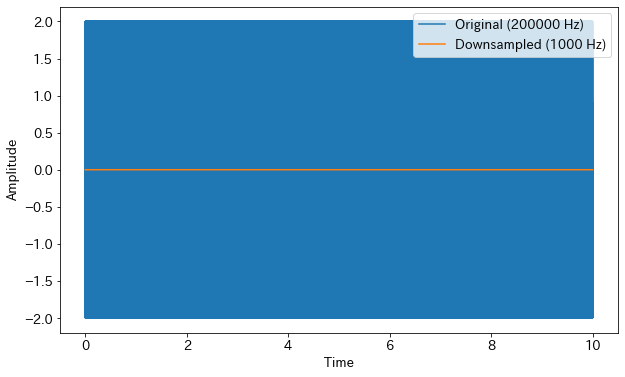

In [76]:
import numpy as np

def downsample(signal, original_sample_rate, target_sample_rate):
    # 計算する間引きの割合を求める
    decimation_factor = original_sample_rate // target_sample_rate
    
    # ダウンサンプリングされたデータの長さを計算
    new_length = len(signal) // decimation_factor
    
    # ダウンサンプリングされたデータを格納するための配列を作成
    downsampled_signal = np.zeros(new_length)
    
    # 平均値を計算して間引き
    for i in range(new_length):
        start_idx = i * decimation_factor
        end_idx = (i + 1) * decimation_factor
        downsampled_signal[i] = np.mean(signal[start_idx:end_idx])
    
    return downsampled_signal

# 仮想的なサンプルデータを生成
original_sample_rate = 200000  # オリジナルのサンプリングレート: 200000 Hz
target_sample_rate = 1000      # ターゲットのサンプリングレート: 1000 Hz
time = np.arange(0, 10, 1/original_sample_rate)
original_signal = np.sin(2 * np.pi * 1000 * time) + np.sin(2 * np.pi * 50000 * time)

# ダウンサンプリング
downsampled_signal = downsample(original_signal, original_sample_rate, target_sample_rate)

# プロットして比較
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(time, original_signal, label='Original (200000 Hz)')
plt.plot(np.arange(0, 10, 1/target_sample_rate), downsampled_signal, label='Downsampled (1000 Hz)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

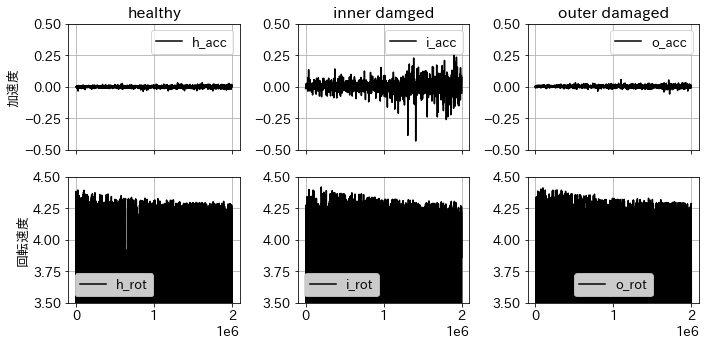

In [94]:
# データ量が多くて表示しきれないので間引くためのインデックスを作る
indices = np.arange(0,df.shape[0],1000)
titles = ["healthy","inner damged","outer damaged"]

plt.rcParams["font.size"] = 13
fig,ax = plt.subplots(figsize=(10,5), ncols=3,nrows=2,sharex=True)
# データを間引きつつグラフ描画
df.iloc[indices].plot(subplots=True, ax=ax, color="k", grid=True)
for n in range(3): 
    ax[0,n].set_title(titles[n])  # タイトル
    ax[0,n].set_ylim(-0.5,0.5)  # y軸範囲指定
    ax[1,n].set_ylim(3.5,4.5)  # x軸範囲指定
ax[0,0].set_ylabel("加速度")
ax[1,0].set_ylabel("回転速度")
fig.tight_layout()
fig.show()

* 健康な軸受は加速度の振幅が小さいようです
* 内部に欠陥をもつ軸受は振幅が大きくなるようです。
* 外部に欠陥をもつ軸受は健康な軸受と見た目大きな違いはなさそうです。

## モデル
* 回転数は振動の振幅に影響しそうです。
* 欠陥も振動の振幅に影響しそうです。
* 健康な軸受のデータだけを使ってモデルを作ってみます。

In [123]:
indices = np.arange(0,df.shape[0],4000)
acc_tr = df["h_acc"].values[indices]
rot_tr = df["h_rot"].values[indices]
N_tr = acc_tr.size

acc_te = df["i_acc"].values[indices]
rot_te = df["i_rot"].values[indices]
N_te = acc_te.size
N_tr, N_te

(500, 500)

## モデル読込み・学習

In [118]:

path = Path(".")
stanfile = path / "bearing_ad_model.stan"
# stanfile = path / "ar.stan"

model = CmdStanModel(stan_file=stanfile)

07:32:43 - cmdstanpy - INFO - compiling stan file /tmp/cmdstanpy/bearing_ad_model__om9xgqc/bearing_ad_model.stan to exe file /tmp/cmdstanpy/bearing_ad_model__om9xgqc/bearing_ad_model
07:33:02 - cmdstanpy - INFO - compiled model executable: /tmp/cmdstanpy/bearing_ad_model__om9xgqc/bearing_ad_model


In [ ]:
data = {
    "acc_tr" : acc_tr,
    "rot_tr" : rot_tr,
    "N_tr": N_tr,
    "acc_te" : acc_te,
    "rot_te" : rot_te,
    "N_te": N_te,
}
# data = {
#     "N_tr": N_tr,
#     "N_te": N_te,
#     "y_tr" : acc_tr,
#     "y_te" : acc_te,
# }
fit = model.sample(
    data=data,
    iter_warmup=300, iter_sampling=1000, chains=3, show_console=False,
    adapt_delta=0.999,
    max_treedepth=20,
)

07:38:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

In [105]:
# 念の為診断
print(fit.diagnose())

Processing csv files: /tmp/tmpbwebajrb/arwde5k47h/ar-20230818065658_1.csv, /tmp/tmpbwebajrb/arwde5k47h/ar-20230818065658_2.csv, /tmp/tmpbwebajrb/arwde5k47h/ar-20230818065658_3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



## 結果の確認

In [106]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,8648.190000,0.047567,1.403150,8645.430000,8648.500000,8649.840000,870.161,7.13112,1.000810
alpha0,0.001590,0.000229,0.008057,-0.011432,0.001605,0.014771,1237.990,10.14560,1.000330
alpha,0.000190,0.000003,0.000180,-0.000107,0.000192,0.000481,2889.950,23.68370,1.001050
beta,0.012848,0.000620,0.022770,-0.024813,0.012737,0.050735,1348.980,11.05510,0.999694
sigma,0.008021,0.000004,0.000128,0.007817,0.008020,0.008234,1075.440,8.81340,1.003620
...,...,...,...,...,...,...,...,...,...
log_lik_te[1996],2.259930,0.030912,1.681290,-1.120500,2.742320,3.889470,2958.230,24.24320,0.999839
log_lik_te[1997],-59.586900,0.211841,11.378800,-78.387600,-59.385100,-41.179000,2885.150,23.64430,1.000620
log_lik_te[1998],-4.368050,0.077773,4.133900,-12.073500,-3.852980,1.437930,2825.250,23.15340,0.999365
log_lik_te[1999],-18.159100,0.125504,6.737780,-29.971100,-17.636900,-8.102650,2882.180,23.62000,1.001270


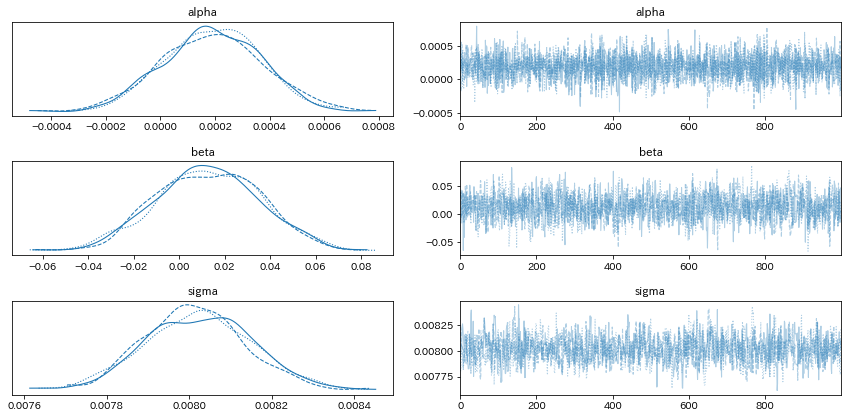

In [107]:
output = az.from_cmdstanpy(posterior=fit)
az.plot_trace(output, var_names=["alpha","beta","sigma"])
plt.tight_layout()

## EAP推定
* 対数尤度が「異常度」の指標になる
* $\log L(y | \hat y, \sigma)$の意味
    * モデルが$\hat y$を推定したときにデータが$y$を取りうる確率の対数
    * 発生確率が小さくなるほど対数尤度も小さくなる
    * 発生確率が小さい＝めったに起こらない＝異常！と考える

In [108]:
samples = fit.stan_variables()

alpha = samples["alpha"].mean(0)
alpha0 = samples["alpha0"].mean(0)
beta = samples["beta"].mean(0)
sigma = samples["sigma"].mean(0)
alpha, beta, sigma, alpha0

(0.00019027101601433335,
 0.012848436495,
 0.008021081436666667,
 0.0015898613472519999)

In [109]:
y_tr_hat_lower, y_tr_hat_upper = np.quantile(samples["y_tr_hat"], [0.025,0.975], axis=0)
y_tr_hat_mean = samples["y_tr_hat"].mean(0)
log_lik_tr_mean = samples["log_lik_tr"].mean(0)

y_te_hat_lower, y_te_hat_upper = np.quantile(samples["y_te_hat"], [0.025,0.975], axis=0)
y_te_hat_mean = samples["y_te_hat"].mean(0)
log_lik_te_mean = samples["log_lik_te"].mean(0)

ValueError: x and y must have same first dimension, but have shapes (100,) and (2000,)

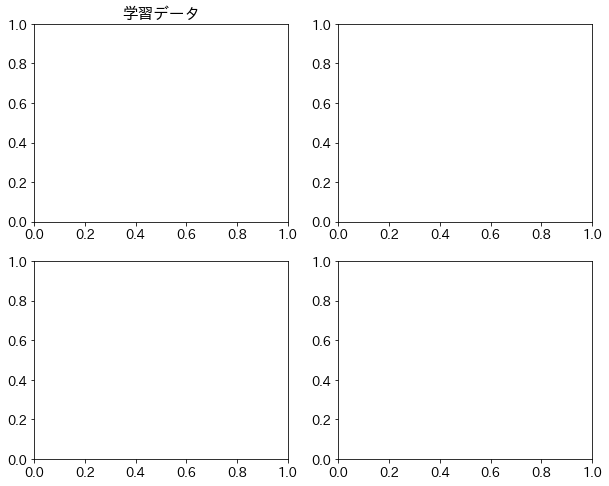

In [111]:
N_tr = 100
N_te = 100
fig,ax = plt.subplots(figsize=(10,8), ncols=2, nrows=2)
ax[0,0].set_title("学習データ")
ax[0,0].plot(np.arange(N_tr), acc_tr, label="実測値")
ax[0,0].plot(y_tr_hat_mean, label="EAP推定値")
ax[0,0].fill_between(np.arange(N_tr), y1=y_tr_hat_lower, y2=y_tr_hat_upper, alpha=0.1, color="r", edgecolor=None, label="95%ベイズ信頼区間")
ax[0,0].legend()
ax[0,0].set_ylabel("$y_{tr}, \hat y_{tr}$")
ax[0,0].set_xlabel("time")
ax[0,0].grid()
ax[0,0].set_ylim(-1.5, 3)

ax[0,1].set_title("テストデータ")
ax[0,1].plot(np.arange(N_tr, N_tr+N_te), acc_te, label="実測値")
ax[0,1].plot(np.arange(N_tr, N_tr+N_te), y_te_hat_mean, label="EAP推定値")
ax[0,1].fill_between(np.arange(N_tr, N_tr+N_te), y1=y_te_hat_lower, y2=y_te_hat_upper, alpha=0.1, color="r", edgecolor=None, label="95%ベイズ信頼区間")
ax[0,1].legend()
ax[0,1].set_ylabel("$y_{te}, \hat y_{te}$")
ax[0,1].set_xlabel("time")
ax[0,1].grid()
ax[0,1].set_ylim(-1.5, 3)

ax[1,0].plot(log_lik_tr_mean)
ax[1,0].grid()
ax[1,0].set_xlabel("time")
ax[1,0].set_ylabel("$\log L(y_{tr} | \hat y_{tr}, \sigma)$")
ax[1,0].set_ylim(-11,0)

ax[1,1].plot(np.arange(N_tr, N_tr+N_te),log_lik_te_mean)
ax[1,1].grid()
ax[1,1].set_xlabel("time")
ax[1,1].set_ylabel("$\log L(y_{te} | \hat y_{te}, \sigma)$")
ax[1,1].set_ylim(-11,0)

fig.tight_layout()
fig.show()


* 実測値が95%ベイズ信頼区間からはみ出る（＝発生確率が小さいデータ）ほど対数尤度が小さくなっていることが確認できた。

EOF